In [1]:
#importacion de librerias necesarias

import numpy as np #para trabajar con arrays num√©ricos.
import matplotlib.pyplot as plt #para hacer gr√°ficos de entrenamiento como curvas de accuracy y loss
from tensorflow.keras.preprocessing.image import ImageDataGenerator #para cargar im√°genes desde carpetas y aplicar transformaciones autom√°ticas (como escalado, rotaci√≥n
from tensorflow.keras.models import Sequential #definir un modelo de red neuronal secuencial (capas apiladas una detr√°s de otra).
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense #importa las capas necesarias para construir la CNN
from tensorflow.keras.optimizers import Adam  #optimizador que ajusta los pesos del modelo, probamos con Adam primero
from sklearn.metrics import classification_report, confusion_matrix #Para evaluar el rendimiento del modelo una vez que ha hecho predicciones

¬øPorque he elegido ADAM como optimizador?

En m√∫ltiples articulos de internet y codigos de competiciones (Kaggle, ImageNet), se ha documentado el uso preferente de Adam en arquitecturas como:

como una CNN b√°sica que queremos hacer


COMO SON NUESTRAS IMAGENES
Tama√±o: 48x48 p√≠xeles (peque√±a)

Color: Escala de grises.

Formato: .jpg

In [2]:
#lECTURA DE NUESTROS DATOS Y FIJAMOS VARIABLES
img_size = 48 #definimos una variable para fijar el tama√±o (alto y ancho) al que se redimensionar√°n todas las im√°genes antes de pasarlas por la red neurona
batch_size = 32 # sacado de la literatura es el n√∫mero de im√°genes que el modelo procesar√° a la vez antes de actualizar los pesos - un EPOCH o paso de entrenamiento
epochs = 25 #cu√°ntas veces el modelo ver√° todo el dataset completo de entrenamiento - lo usaremos en el .fit
ruta_train = r"C:\Users\anaco\Downloads\data\archive\train"
ruta_test = r"C:\Users\anaco\Downloads\data\archive\test"    

In [3]:
#TRATAMIENTO DE IMAGENES
#Leer las im√°genes manualmente desde carpetas.

#Convertirlas a escala de grises, redimensionarlas a 48x48.

#Almacenar las im√°genes en X_train, y las etiquetas como n√∫meros en y_train (nuestras Y van a ser las emociones que queremos predecir, pero en formato numerico).

#Normalizar las im√°genes a [0, 1].

import glob
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# LISTA MANUAL DE ETIQUETAS (seg√∫n nuestras carpetas)
etiquetas = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Creamos una funci√≥n para cargar im√°genes desde una ruta base, porque tendremos que aplicar esto a nuestras fotos de train y fotos de test
def cargar_imagenes_y_etiquetas(ruta_base, etiquetas, img_size):
    X = []
    y = []
    for etiqueta in etiquetas:
        ruta_carpeta = fr"{ruta_base}\{etiqueta}\*.jpg"
        for ruta_imagen in glob.glob(ruta_carpeta):
            try:
                img = Image.open(ruta_imagen).convert("L").resize((img_size, img_size))
                X.append(np.array(img))
                y.append(etiqueta)
            except Exception as e:
                print(f"Error en {ruta_imagen}: {e}")
    X = np.array(X).reshape(-1, img_size, img_size, 1).astype("float32") / 255.0
    y = np.array(y)
    return X, y

# Cargar TRAIN
X_train, y_train_raw = cargar_imagenes_y_etiquetas(ruta_train, etiquetas, img_size)

# Cargar TEST
X_test, y_test_raw = cargar_imagenes_y_etiquetas(ruta_test, etiquetas, img_size)

# Codificar etiquetas en n√∫meros
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)  # usar el mismo encoder

# Confirmar formas y carga correcta de datos
print(f"imagenes de entrenamiento normalizadas: {X_train.shape} | etiquetas codificadas: {y_train.shape}")
print(f"imagenes de test normalizadas: {X_test.shape}  | etiquetas codificadas para test: {y_test.shape}")
print("Clases:", le.classes_)

imagenes de entrenamiento normalizadas: (28709, 48, 48, 1) | etiquetas codificadas: (28709,)
imagenes de test normalizadas: (7178, 48, 48, 1)  | etiquetas codificadas para test: (7178,)
Clases: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


Conclusion: con esos resultados confirmamos que la carga y preprocesamiento del dataset fue un √©xito total

Por curiosidad y totalmente opcional 
vamos a visualizar una imagen normal vs normalizada. 
Visualmente ambas im√°genes se ven igual, porque el ojo no distingue 
entre escala [0‚Äì255] y [0‚Äì1] si el contraste relativo es el mismo
Pero internamente, los valores de la imagen normalizada est√°n entre 0 y 1, 
y eso es clave para el entrenamiento del modelo

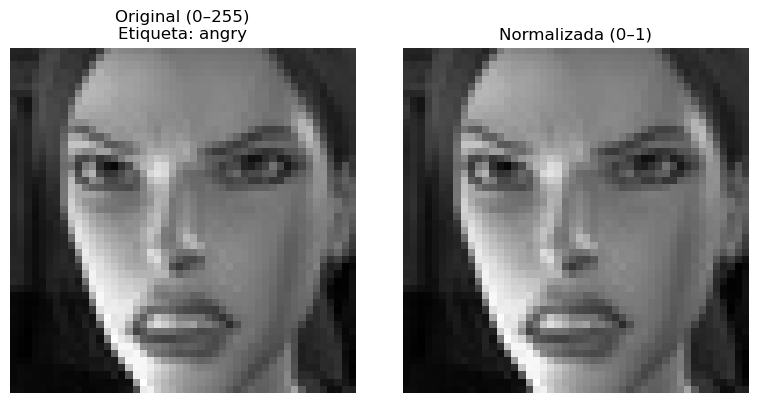

In [4]:
# Seleccionamos una imagen (la 50, por ejemplo)
imagen_normalizada = X_train[5]
etiqueta_codificada = y_train[5]
etiqueta_texto = le.inverse_transform([etiqueta_codificada])[0] # usamos .inverse_transform() para convertir de n√∫mero a texto (por ejemplo, 4 ‚Üí 'happy').

# Para comparaci√≥n, recreamos la imagen original (des-normalizada)
imagen_original = imagen_normalizada * 255

# Convertir a 2D para mostrar
original_2d = imagen_original.reshape(img_size, img_size)
normalizada_2d = imagen_normalizada.reshape(img_size, img_size)

# Dibujar graficamente
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_2d, cmap='gray')
plt.title(f"Original (0‚Äì255)\nEtiqueta: {etiqueta_texto}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(normalizada_2d, cmap='gray')
plt.title("Normalizada (0‚Äì1)")
plt.axis("off")

plt.tight_layout()
plt.show()

In [5]:
#Creamos ahora el modelo muy simple de una red neuronal CNN 


# N√∫mero de clases
num_clases = len(np.unique(y_train))  # 7

# Definimos el modelo
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48, 48, 1)), # Capa convolucional con 32 filtros , filtro (3x3 p√≠xeles) 
    #y un tama√±o de entrada: 48x48 p√≠xeles con 1 canal (escala de grises)
    MaxPooling2D(2,2), #haciendo una reduccion de las imagenes en un factor de 2 ayuda a reducir el coste computacional y hace que el modelo sea m√°s robusto al ruido
    
    Conv2D(64, (3,3), activation='relu'), #Segunda capa convolucional con 64 filtros y el mismo tama√±o de filtro para patrones de bordes y texturas
    MaxPooling2D(2,2), #reducimos de nuevo a la mitad el tama√±o (24x24 ‚Üí 12x12), conservando las caracter√≠sticas m√°s relevantes.
    
    Dropout(0.25), # desactiva aleatoriamente el 25% de las neuronas en esta capa durante el entrenamiento para prevenir overfitting
    Flatten(), #paso para convertir la salida 3D (por ejemplo, 12x12x64) en un vector 1D para poder pasarlo a capas densas totalmente conectads
    
    Dense(128, activation='relu'),#capa de 128 neuronas que es la que aprende combinaciones de las caracter√≠sticas extra√≠das para ayudar a la clasificaci√≥n
    Dropout(0.5),#desactivamos el 50% de neuronas para evitar overfit
    
    Dense(num_clases, activation='softmax')  # salida softmax para 7 clases de emociones 
    #Softmax devuelve probabilidades para cada clase: la suma da 1 y la mayor indica la predicci√≥n final
])

# Compilamos el modelo con sparse categorical_crossentropy
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Ya hemos visto que nuestras clases estan desbalanceadas. Vamos a aplicar tecnicas de data augmentation en la parte del codigo de abajo

Primero: Detectamos qu√© clases tienen menos im√°genes.

Segundo: Creamos nuevas im√°genes para esas clases, aplicando transformaciones visuales (data augmentation).

Tercero: Mezclamos esas nuevas im√°genes que hemos creado con las originales.

Luego entrenamos la red neuronal con un conjunto mas equilibrado comparando los resultados con el modelo anterior sin DA

In [6]:
from collections import Counter #en la literatura hemos encontrado esta funcion que nos permite contar cu√°ntas im√°genes hay por clase.
from tensorflow.keras.preprocessing.image import ImageDataGenerator #es la funcion de Keras que aplica transformaciones a las im√°genes para crear versiones nuevas.

# Contamos cu√°ntas im√°genes hay por clase
conteo_clases = Counter(y_train)
max_count = max(conteo_clases.values()) #obtenemos el n√∫mero de la clase mayoritaria (max_count).
#Esto nos sirve para saber cu√°ntas im√°genes debemos generar para igualar las clases minoritarias, y lo guardamos en una variable que usaremos cuando aumentemos las clases.

# Crear generador de augmentaci√≥n, configurandolo con las modificaciones que queremos hacer a las imagenes creadas
datagen = ImageDataGenerator(
    rotation_range=15, #Rota aleatoriamente la imagen entre -15 y +15 grados
    width_shift_range=0.1,  # Desplaza horizontalmente la imagen hasta un 10% del ancho
    height_shift_range=0.1, # Desplaza verticalmente hasta un 10% de la altura
    zoom_range=0.1, # Hace zoom aleatorio dentro del 90%-110% del tama√±o
    horizontal_flip=True,# Invierte 180 grados la imagen (efecto espejo)
    fill_mode='nearest' # Rellena los p√≠xeles nuevos usando el valor m√°s cercano
)

# Crear listas para guardar las nuevas im√°genes augmentadas
X_augmented = []
y_augmented = []

# Aumentar solo las clases minoritarias
for clase, count in conteo_clases.items():
    if count < max_count:
        num_to_generate = max_count - count
        indices = np.where(y_train == clase)[0]
        X_clase = X_train[indices]

        for i in range(num_to_generate):
            idx = i % len(X_clase)
            image = X_clase[idx]
            image = np.expand_dims(image, 0)
            for batch in datagen.flow(image, batch_size=1):
                X_augmented.append(batch[0])
                y_augmented.append(clase)
                break

# Combinar con datos originales
X_train = np.concatenate([X_train, np.array(X_augmented)])
y_train = np.concatenate([y_train, np.array(y_augmented)])

# Confirmar que ahora todas las clases tienen el mismo n√∫mero de im√°genes
from collections import Counter
print("Conteo de clases tras data augmentation:", Counter(y_train))

‚úÖ Nuevo conteo de clases tras data augmentation: Counter({0: 7215, 1: 7215, 2: 7215, 3: 7215, 4: 7215, 5: 7215, 6: 7215})


In [ ]:
# Entrenamos el modelo directamente con y_train e y_test (enteros)
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/25
1579/1579 [==============================] - 159s 98ms/step - loss: 1.7650 - accuracy: 0.3062 - val_loss: 1.5213 - val_accuracy: 0.4320
Epoch 2/25
1579/1579 [==============================] - 151s 96ms/step - loss: 1.5549 - accuracy: 0.4095 - val_loss: 1.4856 - val_accuracy: 0.4366
Epoch 3/25
1579/1579 [==============================] - 149s 94ms/step - loss: 1.4658 - accuracy: 0.4456 - val_loss: 1.3544 - val_accuracy: 0.4780
Epoch 4/25
1579/1579 [==============================] - 148s 94ms/step - loss: 1.4036 - accuracy: 0.4693 - val_loss: 1.3845 - val_accuracy: 0.4751
Epoch 5/25
1579/1579 [==============================] - 149s 94ms/step - loss: 1.3607 - accuracy: 0.4849 - val_loss: 1.2711 - val_accuracy: 0.5100
Epoch 6/25
1579/1579 [==============================] - 151s 96ms/step - loss: 1.3201 - accuracy: 0.5020 - val_loss: 1.2760 - val_accuracy: 0.5121
Epoch 7/25
1579/1579 [==============================] - 151s 95ms/step - loss: 1.2327 - accuracy: 0.5373 - val_loss: 1

225/225 [==============================] - 7s 28ms/step
üîç Clasification Report:

              precision    recall  f1-score   support

       angry       0.45      0.40      0.43       958
     disgust       0.25      0.56      0.34       111
        fear       0.46      0.31      0.37      1024
       happy       0.78      0.73      0.75      1774
     neutral       0.46      0.59      0.52      1233
         sad       0.43      0.40      0.42      1247
    surprise       0.65      0.78      0.71       831

    accuracy                           0.55      7178
   macro avg       0.50      0.54      0.51      7178
weighted avg       0.55      0.55      0.54      7178



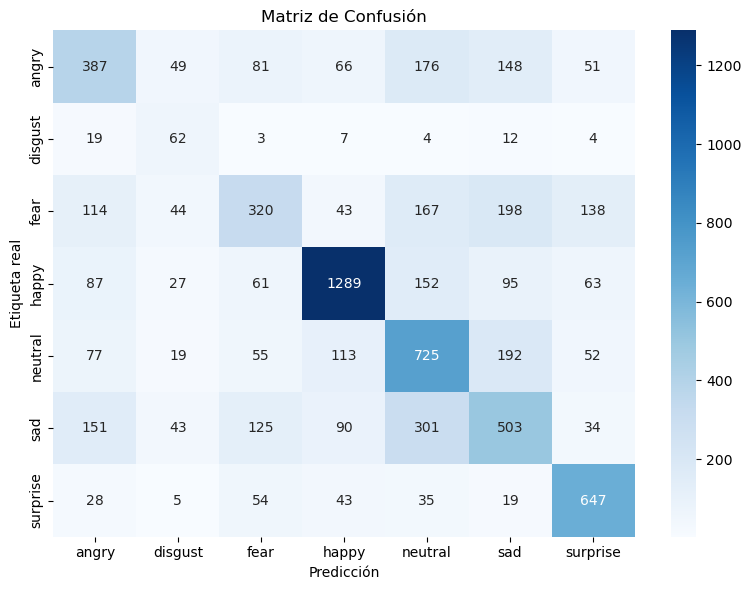

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predicci√≥n
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)

# Reporte por clase
print("üîç Clasification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Matriz de confusi√≥n
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicci√≥n")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusi√≥n")
plt.tight_layout()
plt.show()

Interpretacion de los resultados:

Los resultados de F1 confirma que tu modelo ha mejorado gracias al data augmentation, especialmente en clases peque√±as como disgust y surprise.

Happy y Surprise: buenas predicciones.

Fear se confunde mucho con sad, angry y surprise.

Sad se confunde con neutral y fear.

Disgust mejora el recall, pero sigue costando distinguirla (muchos falsos positivos).